In [32]:
%matplotlib inline
import geohash
import geopandas as gp
import pandas as pd
import geojson
from geojson import MultiLineString
from shapely import geometry
from shapely.geometry import Point, Polygon, box
from geopandas import datasets, GeoDataFrame, read_file
from geopandas.tools import overlay

Autosave disabled


### AHMAD FAIRUZ BIN ALI 

In [9]:
def is_geohash_in_bounding_box(current_geohash, bbox_coordinates):
    """Checks if the box of a geohash is inside the bounding box

    :param current_geohash: a geohash
    :param bbox_coordinates: bounding box coordinates
    :return: true if the the center of the geohash is in the bounding box
    """

    coordinates = geohash.decode(current_geohash)
    geohash_in_bounding_box = (bbox_coordinates[0] < coordinates[0] < bbox_coordinates[2]) and (
            bbox_coordinates[1] < coordinates[1] < bbox_coordinates[3])
    return geohash_in_bounding_box
def build_geohash_box(current_geohash):
    """Returns a GeoJSON Polygon for a given geohash

    :param current_geohash: a geohash
    :return: a list representation of th polygon
    """

    b = geohash.bbox(current_geohash)
    polygon = [(b['w'], b['s']), (b['w'], b['n']), (b['e'], b['n']), (b['e'], b['s'],), (b['w'], b['s'])]
    return polygon
def compute_geohash_tiles(bbox_coordinates,GEOHASH_PRECISION):
    """Computes all geohash tile in the given bounding box

    :param bbox_coordinates: the bounding box coordinates of the geohashes
    :return: a list of geohashes
    """

    checked_geohashes = set()
    geohash_stack = set()
    geohashes = []
    # get center of bounding box, assuming the earth is flat ;)
    center_latitude = (bbox_coordinates[0] + bbox_coordinates[2]) / 2
    center_longitude = (bbox_coordinates[1] + bbox_coordinates[3]) / 2

    center_geohash = geohash.encode(center_latitude, center_longitude, precision=GEOHASH_PRECISION)
    geohashes.append(center_geohash)
    geohash_stack.add(center_geohash)
    checked_geohashes.add(center_geohash)
    while len(geohash_stack) > 0:
        current_geohash = geohash_stack.pop()
        neighbors = geohash.neighbors(current_geohash)
        for neighbor in neighbors:
            if neighbor not in checked_geohashes and is_geohash_in_bounding_box(neighbor, bbox_coordinates):
                geohashes.append(neighbor)
                geohash_stack.add(neighbor)
                checked_geohashes.add(neighbor)
    return geohashes
def create_polygon(coordinates):
    polygon_geom = Polygon(coordinates)
    crs = {'init': 'epsg:4326'}
    polygon = gp.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])     
    return polygon.geometry # return polygon['geometry']
# this function is for save the geohashes into a json file 
def write_geohash_layer(geohashes,filename):
    """Writes a grid layer based on the geohashes

    :param geohashes: a list of geohashes
    """

    layer = MultiLineString([build_geohash_box(gh) for gh in geohashes])
    with open('result/' + filename + '.json', 'wb') as f:
        f.write(geojson.dumps(layer,sort_keys=True).encode('utf-8'))

def compute_geohash_tiles_from_polygon(polygon,GEOHASH_PRECISION):
    """Computes all hex tile in the given polygon

    :param polygon: the polygon
    :return: a list of geohashes
    """

    checked_geohashes = set()
    geohash_stack = set()
    geohashes = []
    # get center of bounding, assuming the earth is flat ;)
    center_latitude = polygon.centroid.coords[0][1]
    center_longitude = polygon.centroid.coords[0][0]

    center_geohash = geohash.encode(center_latitude, center_longitude, precision=GEOHASH_PRECISION)
    geohashes.append(center_geohash)
    geohash_stack.add(center_geohash)
    checked_geohashes.add(center_geohash)
    while len(geohash_stack) > 0:
        current_geohash = geohash_stack.pop()
        neighbors = geohash.neighbors(current_geohash)
        for neighbor in neighbors:
            point = geometry.Point(geohash.decode(neighbor)[::-1])
            if neighbor not in checked_geohashes and polygon.contains(point):
                geohashes.append(neighbor)
                geohash_stack.add(neighbor)
                checked_geohashes.add(neighbor)
    return geohashes

In [10]:
# STEP 1
# Bigger area for Yangon 
#bbox_coordinates = [16.321394, 95.760679, 17.901337, 96.928519] # kawasan kecil berpusatkan edotcoMyanmar office. 
#bbox_coordinates = [16.771534, 96.113091,16.823357, 96.210089] # kawasan besar sket disebabkan oleh kawasan di atas tiada banyak 4G cell

#
# Magway 
#bbox_coordinates = [20.116729, 94.913584,20.179886, 94.972777]

#zamboanga
#bbox_coordinates = [6.810631, 121.689455, 8.882895, 123.729821]
bbox_coordinates = [6.905160, 122.043943,6.928318, 122.095724]

#whole city
bbox_coordinates = [6.820630, 121.843974, 7.486918, 122.459944]

concentratedarea = compute_geohash_tiles(bbox_coordinates,7)
print(len(concentratedarea))
concentratedarea[1]

217765


'w9qbew7'

In [11]:
len(concentratedarea)

217765

In [12]:
# STEP 2 
# CONVERT THE COORDINATES INTO POLYGON
myshape = pd.DataFrame(concentratedarea)
myshape.columns = ['geohash']
# # tak yah buat di bawah pun tak ngapa
myshape['coordinates'] = myshape['geohash'].map(lambda x:build_geohash_box(x))

In [13]:
# STEP 3 
# create the polygon  
myshape['geometry'] = myshape['coordinates'].apply(lambda x:create_polygon(x))

In [14]:
# STEP 4 
# convert the pandas into geopandas 
crs = {'init': 'epsg:4326'}
myshape = GeoDataFrame(myshape, crs=crs, geometry=myshape['geometry'])
del myshape['coordinates']

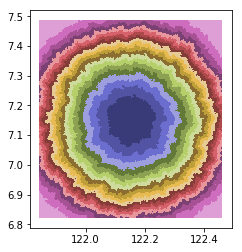

In [44]:
# step 6
myshape.plot(cmap='tab20b')

In [15]:
myshape.head(1)

,geohash,geometry
0,w9qbewk,"POLYGON ((122.1514892578125 7.153472900390625,..."


In [16]:
myshape.shape

(217765, 2)

In [17]:
myshape = myshape.to_crs({'init': 'epsg:4326'})

In [22]:
# STEP 7
# LOAD THE YANGON POLYGON RECEIVED FROM SAY AND CONVERTED BY AMIR
#yangon_city = gp.read_file("D:/Work/30_geohash/result/yangon_city")
#
#from remove_third_dimension import remove_third_dimension
# load the file Magwe for magway
#magwaycity_region = gp.read_file('D:/Work/26_edotco_myanmar/OM_Say/E.coPOC_esri/MagwayCIty_region.shp')
#magwaycity_region['geometry'] = magwaycity_region['geometry'].map(lambda x:remove_third_dimension(x))
#magwaycity_region = magwaycity_region.to_crs({'init': 'epsg:4326'})
regions = gp.read_file("Shape Files/")
zamboanga = regions[regions['NAME_2']=='Zamboanga City'].to_crs({'init': 'epsg:4326'})

In [23]:
zamboanga

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,GID_3,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
41462,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.1_1,Arena Blanco,None,None,Barangay,Village,None,None,"POLYGON ((122.1422195434571 6.928060054779053,..."
41463,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.2_1,Ayala,None,None,Barangay,Village,None,None,"POLYGON ((121.9615631103516 6.96274995803833, ..."
41464,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.3_1,Baliwasan,None,None,Barangay,Village,None,None,"POLYGON ((122.0610885620117 6.915569782257023,..."
41465,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.4_1,Baluno,None,None,Barangay,Village,None,None,"POLYGON ((122.0286026000977 6.996260166168327,..."
41466,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.5_1,Barangay Zone I,Poblacion,None,Barangay,Village,None,None,"POLYGON ((122.0769577026367 6.908999919891414,..."
41467,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.6_1,Barangay Zone II,Poblacion,None,Barangay,Village,None,None,"POLYGON ((122.0694198608399 6.91278982162487, ..."
41468,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.7_1,Barangay Zone III,Poblacion,None,Barangay,Village,None,None,"POLYGON ((122.0742568969727 6.916689872741756,..."
41469,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.8_1,Barangay Zone IV,Poblacion,None,Barangay,Village,None,None,"POLYGON ((122.0792770385743 6.90828990936285, ..."
41470,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.9_1,Boalan,None,None,Barangay,Village,None,None,"POLYGON ((122.1323471069337 6.961150169372559,..."
41471,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.10_1,Bolong,None,None,Barangay,Village,None,None,"POLYGON ((122.2474899291995 7.101309776306096,..."


In [47]:
# STEP 11
# PERFORM THE INTERSECTION
#myintersection = overlay(yangon_city, myshape, how="intersection")
#myintersection = overlay(magwaycity_region, myshape, how="intersection")
myintersection = overlay(zamboanga,myshape,how='intersection')

In [23]:
myshape.shape

(629, 2)

In [22]:
myintersection.shape

(753, 18)

In [48]:
# STEP 12 
#myintersection.plot(cmap='tab20b')
#myintersection.to_file("result/" + city + "intersection")
#myintersection.to_file("result/yangon_edotcoOfis_geohash")
#myintersection.to_file("result/yangon_edotco15March")
#myintersection.to_file("result/magwaycityregion_geohash")
myintersection.to_file("zamboanga_geohash")

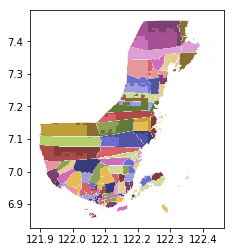

In [3]:
myintersection.plot(cmap='tab20b')

## NOTES : ONCE YOU HAVE THE INTERSECTION FILES READY , THEN YOU SHOULD DO THE UNION WITH THE BUILDINGS USING QGIS 

In [18]:
roads = gp.read_file("tmp/")

In [33]:
tmp = roads.to_crs({'init': 'epsg:4326'})

In [20]:
test = overlay(myshape,roads,how='intersection')

TypeError: overlay only takes GeoDataFrames with (multi)polygon  geometries.

In [14]:
roads = gp.read_file("Zamboanga City roads-merged.shp")

In [15]:
ECKERT_IV_PROJ4_STRING = "+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

tmp = roads.to_crs(ECKERT_IV_PROJ4_STRING)
tmp['lenght'] = tmp['geometry'].length

In [37]:
tmp.groupby('geohash')['osm_id'].agg('count')

geohash
w9nxrzp     1
w9nxrzq     1
w9nxrzr     6
w9nxrzt     1
w9nxrzv     1
w9nxrzw     4
w9nxrzx    10
w9nxrzz     2
w9nxwfx     3
w9nxwfz     1
w9nxwge     1
w9nxwgg     1
w9nxwgr     1
w9nxwgt     1
w9nxwgu     2
w9nxwgv     2
w9nxwgw     2
w9nxwgx     3
w9nxwgy     2
w9nxwgz     3
w9nxwrz     1
w9nxwsv     1
w9nxwsx     1
w9nxwsy     2
w9nxwtj     1
w9nxwtm     2
w9nxwtn     3
w9nxwtp     2
w9nxwtq     3
w9nxwtr     6
           ..
w9qfrwm     2
w9qfrwt     1
w9qfrww     1
w9r1bhn     1
w9r1bhq     1
w9r1bhw     1
w9r1bhy     2
w9r1bjn     1
w9r1bjq     1
w9r1bjt     1
w9r1bju     1
w9r1bjv     1
w9r1bjw     1
w9r1bn5     1
w9r1bn6     1
w9r1bn7     1
w9r1bnc     1
w9r1bnd     1
w9r1bnf     1
w9r1bnh     1
w9r1bp1     1
w9r1bp3     1
w9r1bp9     1
w9r1bpc     1
w9r4001     1
w9r4002     1
w9r4003     1
w9r4008     1
w9r400b     1
w9r4010     1
Name: osm_id, Length: 7448, dtype: int64

In [16]:
tmp1 = tmp.groupby('geohash')['lenght'].agg('sum')

In [17]:
tt = tmp1.to_frame().reset_index()

In [18]:
myintersection = gp.read_file("zamboanga_geohash/")

In [19]:
x = pd.merge(myintersection,tt,how='left')

In [30]:
ECKERT_IV_PROJ4_STRING = "+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

tt = roads.to_crs(ECKERT_IV_PROJ4_STRING)
tt.length

0          9.072109
1         48.073660
2         14.610652
3         39.165857
4        545.271105
5        386.591132
6          7.553375
7         57.010165
8         56.212026
9         48.057763
10       242.637288
11        37.355782
12       107.746309
13       300.667561
14       229.140465
15       551.586334
16       613.897504
17        11.802520
18        26.937709
19        68.797212
20        53.873448
21        55.771632
22        59.072040
23        45.871720
24       156.554106
25        61.617690
26       835.715937
27         9.497843
28        44.766392
29       236.981405
           ...     
5478      12.283807
5479      22.021769
5480      61.385847
5481      40.267389
5482       8.495075
5483       9.698649
5484     191.610177
5485      25.067618
5486     112.465886
5487      31.908639
5488      22.490303
5489      79.760569
5490     253.896609
5491     168.053633
5492     108.541881
5493      32.250870
5494      15.176153
5495     114.669940
5496     321.147254


In [3]:
Build = gp.read_file("Building/")

In [8]:
aa  =Build.to_crs({'init': 'epsg:3857'})

In [44]:
aa['area'] = aa['geometry'].area

0         67.540363
1        112.591807
2         41.774740
3        121.147772
4         32.005407
5        110.839312
6         26.170834
7         56.538492
8        128.987971
9        111.780671
10        22.737918
11      1039.078601
12       189.377286
13       147.411721
14       292.541116
15       150.523210
16        60.760936
17       139.331641
18       181.129234
19       103.758651
20        97.211811
21        71.744291
22        50.816738
23       155.994209
24        49.123649
25        81.972055
26        63.229888
27       105.896233
28       111.836138
29       296.722865
           ...     
9729     265.505399
9730     194.143385
9731      10.082546
9732     105.674355
9733       1.238947
9734     391.893625
9735      66.064675
9736     664.828975
9737      66.013020
9738      99.599715
9739     239.195430
9740     317.385271
9741     360.679136
9742      77.312919
9743      94.869339
9744      53.289450
9745     129.736740
9746     106.747984
9747     791.111023


In [43]:
aa

,osm_id,code,fclass,name,type,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,...,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geohash,geometry,area
0,477299196,1500,building,None,None,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,...,Santa Maria,None,None,Barangay,Village,None,None,w9nz3xq,"POLYGON ((13588460.66163101 774494.7304376272,...",67.540363
1,477299187,1500,building,None,None,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,...,Santa Maria,None,None,Barangay,Village,None,None,w9nz3xx,"POLYGON ((13588516.26636893 774601.359497113, ...",112.591807
2,477299187,1500,building,None,None,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,...,Santa Maria,None,None,Barangay,Village,None,None,w9nz3xw,"POLYGON ((13588511.70161754 774601.2086250099,...",41.774740
3,477299186,1500,building,None,None,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,...,Santa Maria,None,None,Barangay,Village,None,None,w9nz3xx,"POLYGON ((13588516.26636893 774590.2713780846,...",121.147772
4,477299186,1500,building,None,None,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,...,Santa Maria,None,None,Barangay,Village,None,None,w9nz3xw,"POLYGON ((13588512.68122906 774590.1514804417,...",32.005407
5,477299185,1500,building,None,None,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,...,Santa Maria,None,None,Barangay,Village,None,None,w9nz3xx,"POLYGON ((13588516.26636893 774579.89736762, 1...",110.839312
6,477299185,1500,building,None,None,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,...,Santa Maria,None,None,Barangay,Village,None,None,w9nz3xw,"POLYGON ((13588513.07084727 774579.7896148171,...",26.170834
7,359445527,1500,building,None,industrial,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,...,Talisayan,None,None,Barangay,Village,None,None,w9nxwrz,"POLYGON ((13572617.36448561 779676.7976049322,...",56.538492
8,359445527,1500,building,None,industrial,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,...,Talisayan,None,None,Barangay,Village,None,None,w9nxwry,"POLYGON ((13572604.41354996 779664.5369988488,...",128.987971
9,477299184,1500,building,None,None,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,...,Santa Maria,None,None,Barangay,Village,None,None,w9nz3xx,"POLYGON ((13588516.26636893 774566.5963722948,...",111.780671


In [34]:
aa.groupby('geohash')['osm_id'].agg('count')

geohash
w9nxwgx     1
w9nxwrx     8
w9nxwry     3
w9nxwrz    15
w9nxwsy     4
w9nxwsz     1
w9nxwtj     1
w9nxwtm     8
w9nxwtn     5
w9nxwtp     8
w9nxwtq     3
w9nxwtr     5
w9nxwts     1
w9nxwtt     7
w9nxwtv     6
w9nxwtw     8
w9nxwtx     3
w9nxwty    12
w9nxwtz     1
w9nxwuy     1
w9nxwuz     3
w9nxwv0     5
w9nxwv2     6
w9nxwvp     1
w9nxww7     1
w9nxwwd     2
w9nxwwe    12
w9nxwwf    14
w9nxwwg    29
w9nxwwj     1
           ..
w9qbqpb     2
w9qbs52     1
w9qbs58     2
w9qbs59     1
w9qbt2j     1
w9qbt2n     3
w9qbtf6     5
w9qbtf7     4
w9qbtfe     7
w9qbtfk     5
w9qbtfm    26
w9qbtfs    27
w9qbtfx     1
w9qbtxb     5
w9qbv5s     8
w9qbv5t     6
w9qbv80     5
w9qbvrw     1
w9qbvrx     2
w9qbvrz    12
w9qbvxb     7
w9qcthc     2
w9qcuu3     2
w9qcyvb     1
w9qcywp     6
w9qcywr     1
w9qcyy0     6
w9qcyy2     2
w9qcyyc     1
w9qcyz1     1
Name: osm_id, Length: 1342, dtype: int64

In [29]:
tmp3 = tmp2.to_frame().reset_index()

In [30]:
xx = pd.merge(x,tmp3,how='left')

In [32]:
xx.to_file('road_buil/')

C:\Users\A1915\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [33]:
poi = gp.read_file("poi_geo_hash.shp")

In [34]:
poi

,osm_id,code,fclass,name,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,...,GID_3,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geohash,geometry
0,269123303,2081.0,university,Universidad de Zamboanga Main Campus,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,...,PHL.80.29.86_1,Tetuan,None,None,Barangay,Village,None,None,w9nz65t,"POLYGON ((122.0869445800781 6.919533447993574,..."
1,269123303,2081.0,university,Universidad de Zamboanga Main Campus,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,...,PHL.80.29.86_1,Tetuan,None,None,Barangay,Village,None,None,w9nz65s,"POLYGON ((122.0863576 6.9191751, 122.0864273 6..."
2,310210307,2252.0,pitch,None,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,...,PHL.80.29.21_1,Canelar,None,None,Barangay,Village,None,None,w9nz3s8,"POLYGON ((122.0587756 6.9248853, 122.0587814 6..."
3,274704540,2251.0,sports_centre,Audience Hall,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,...,PHL.80.29.16_1,Cacao,None,None,Barangay,Village,None,None,w9nzuqm,"POLYGON ((122.1862017 7.0225246, 122.1863513 7..."
4,269118249,2252.0,pitch,None,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,...,PHL.80.29.83_1,Talisayan,None,None,Barangay,Village,None,None,w9nxy3m,"POLYGON ((121.9228967043159 6.994171142578125,..."
5,269118249,2252.0,pitch,None,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,...,PHL.80.29.83_1,Talisayan,None,None,Barangay,Village,None,None,w9nxy3j,"POLYGON ((121.922855 6.9941619, 121.9228967043..."
6,310210303,2252.0,pitch,None,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,...,PHL.80.29.21_1,Canelar,None,None,Barangay,Village,None,None,w9nz3kw,"POLYGON ((122.056663 6.924474, 122.056663 6.92..."
7,310210303,2252.0,pitch,None,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,...,PHL.80.29.21_1,Canelar,None,None,Barangay,Village,None,None,w9nz3kx,"POLYGON ((122.0567321777344 6.924563033325196,..."
8,477246161,2252.0,pitch,Alexandra cockpit,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,...,PHL.80.29.93_1,Tumaga,None,None,Barangay,Village,None,None,w9nz9br,"POLYGON ((122.0790777 6.9456736, 122.0791327 6..."
9,274704537,2007.0,library,MNHS Library,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,...,PHL.80.29.16_1,Cacao,None,None,Barangay,Village,None,None,w9nzuqt,"POLYGON ((122.1865438 7.0233001, 122.1866433 7..."


In [44]:
a  = poi.groupby(['geohash','fclass'])['osm_id'].agg('count')

In [45]:
a = a.to_frame().reset_index()

In [49]:
a.rename(columns={'osm_id':'total_poi'},inplace=True)

In [38]:
al = gp.read_file('road_buil_inter/')

In [50]:
x = pd.merge(al,a,how='left')

In [51]:
x

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,GID_3,NAME_3,...,ENGTYPE_3,CC_3,HASC_3,geohash,lenght,area,count,geometry,fclass,total_poi
0,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.1_1,Arena Blanco,...,Village,None,None,w9nz7tx,NaN,NaN,NaN,"POLYGON ((122.156982421875 6.930830001831055, ...",NaN,NaN
1,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.1_1,Arena Blanco,...,Village,None,None,w9nz7v8,NaN,NaN,NaN,"POLYGON ((122.1576724206772 6.930999755859375,...",NaN,NaN
2,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.1_1,Arena Blanco,...,Village,None,None,w9nz7vf,NaN,NaN,NaN,"POLYGON ((122.1611022949219 6.931670188903865,...",NaN,NaN
3,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.1_1,Arena Blanco,...,Village,None,None,w9nz7vc,NaN,NaN,NaN,"POLYGON ((122.1597290039063 6.931389808654899,...",NaN,NaN
4,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.1_1,Arena Blanco,...,Village,None,None,w9nz7ty,NaN,NaN,NaN,"POLYGON ((122.1542358398438 6.930999755859375,...",NaN,NaN
5,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.1_1,Arena Blanco,...,Village,None,None,w9nz7vg,NaN,NaN,NaN,"POLYGON ((122.1624755859375 6.93221998214733, ...",NaN,NaN
6,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.1_1,Arena Blanco,...,Village,None,None,w9nz7vu,NaN,NaN,NaN,"POLYGON ((122.1632090735882 6.932373046875, 12...",NaN,NaN
7,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.1_1,Arena Blanco,...,Village,None,None,w9nz7vb,NaN,NaN,NaN,"POLYGON ((122.1583557128906 6.931389808654899,...",NaN,NaN
8,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.1_1,Arena Blanco,...,Village,None,None,w9nz7tz,NaN,NaN,NaN,"POLYGON ((122.1556091308594 6.930999755859375,...",NaN,NaN
9,PHL,Philippines,PHL.80_1,Zamboanga del Sur,None,PHL.80.29_1,Zamboanga City,None,PHL.80.29.1_1,Arena Blanco,...,Village,None,None,w9nz7wn,193.238762,NaN,2.0,"POLYGON ((122.1542358398438 6.933022127077273,...",NaN,NaN


In [52]:
x.to_file('road_buil_inter_poi/')

C:\Users\A1915\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
